In [ ]:
# STEP 1: Install dependencies
!pip install transformers datasets torch scikit-learn matplotlib emoji

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 608.4/608.4 kB 17.2 MB/s eta 0:00:00


In [ ]:
# STEP 2: Import libraries
import pandas as pd
import numpy as np
import re, emoji
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset

In [ ]:
# STEP 3: Upload the dataset
from google.colab import files
uploaded = files.upload()  # Choose "synthetic_virtual_psychiatrist_text_dataset.csv"

Saving balanced_virtual_psychiatrist_dataset.csv to balanced_virtual_psychiatrist_dataset.csv


In [ ]:
# STEP 4: Load dataset
df = pd.read_csv("balanced_virtual_psychiatrist_dataset.csv")
print("✅ Dataset loaded successfully!")
print(f"Dataset shape: {df.shape}")
print(df.head())


✅ Dataset loaded successfully!
Dataset shape: (3332, 6)
                                user_id session_id  \
0  83da2a41-0f3e-43ca-b93c-e17eb3f7447a   e5390faa   
1  e73acfe4-6763-4a94-a208-fe77dc02dd6a   74b32e24   
2  bb466944-db9d-4867-afae-52033360cfff   80ecc485   
3  91728d7f-8cac-4473-a17e-417076a56aed   9533bfa3   
4  34846cbf-deaa-4e13-85ee-88b780ad6457   bf6605a5   

                                           user_text  \
0  i cannot believe they said actually that it ma...   
1           im fed i guess up and boiling with anger   
2  im extremely upset about how they treated me t...   
3  im fed up and boiling wiht anger what should i do   
4    im really upset abuot how they treated me today   

                                  psychiatrist_reply predicted_emotion  \
0  I hear how angry that made you. Can you tell m...             angry   
1  It makes sense you feel angry. What do you wan...             angry   
2  That sounds upsetting. When did this occur and...        

In [ ]:
# ==============================                                                                           # STEP 5: Preprocessing Function
# ==============================

import re, unicodedata, pandas as pd

def clean_text_v3(text):
    """
    Safer cleaning that preserves contractions ('I'm'), punctuation cues (!, ?), and emotive words.
    Removes URLs, mentions, most emoji ranges and odd unicode, normalizes whitespace.
    """
    if pd.isna(text):
        return ""
    s = unicodedata.normalize("NFKC", str(text))    # normalize punctuation, apostrophes, etc.
    s = s.lower().strip()
    # remove URLs and mentions
    s = re.sub(r"http\S+|www\.\S+|@\w+", " ", s)
    # remove hash symbol but keep the word
    s = re.sub(r"#", " ", s)
    # remove common emoji unicode ranges (replace with space)
    emoji_pattern = re.compile("[\U0001F600-\U0001F64F"
                               "\U0001F300-\U0001F5FF"
                               "\U0001F680-\U0001F6FF"
                               "\U0001F1E0-\U0001F1FF"
                               "\U00002700-\U000027BF"
                               "\U0001F900-\U0001F9FF"
                               "]+", flags=re.UNICODE)
    s = emoji_pattern.sub(" ", s)
    # keep letters, numbers and basic punctuation . , ? ! : ' - ( ) — preserves contractions & emotive markers
    s = re.sub(r"[^0-9a-zA-Z\s\.\,\?\!\:\'\-\(\)]", " ", s)
    # collapse repeated punctuation like "!!!" -> "!"
    s = re.sub(r'([.!?])\1+', r'\1', s)
    # normalize whitespace
    s = re.sub(r"\s+", " ", s).strip()
    # strip leading/trailing punctuation leftover
    s = s.strip(" .,!?:;'\"-()")
    return s

# Example usage:
# df['user_text_clean'] = df['user_text'].apply(clean_text_v3)
# df = df[df['user_text_clean'].str.len() >= 3]   # drop only extremely short / empty rows


print(f"✅ Cleaned dataset shape: {df.shape}")


✅ Cleaned dataset shape: (3332, 6)


In [ ]:
# STEP 6: Label Encoding
# ==============================

le = LabelEncoder()
df['label'] = le.fit_transform(df['predicted_emotion'])
print("✅ Encoded labels:", dict(zip(le.classes_, range(len(le.classes_)))))



✅ Encoded labels: {'angry': 0, 'anxious': 1, 'happy': 2, 'neutral': 3, 'sad': 4, 'stressed': 5, 'tired': 6}


In [ ]:
# ==============================                                                                                    # STEP 7: Split Train/Test
# ==============================

train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['label'])
train_ds = Dataset.from_pandas(train_df)
test_ds = Dataset.from_pandas(test_df)



In [ ]:
# ==============================                                                                                    # STEP 8: Tokenization
# ==============================

model_name = "distilbert-base-uncased"  # or "mental/mental-bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)

def tokenize_function(example):
    return tokenizer(example['user_text'], truncation=True, padding='max_length', max_length=128)

train_ds = train_ds.map(tokenize_function, batched=True)
test_ds = test_ds.map(tokenize_function, batched=True)

train_ds = train_ds.rename_column("label", "labels")
test_ds = test_ds.rename_column("label", "labels")
train_ds.set_format("torch", columns=["input_ids", "attention_mask", "labels"])
test_ds.set_format("torch", columns=["input_ids", "attention_mask", "labels"])



NameError: name 'AutoTokenizer' is not defined

In [ ]:
# ==============================                                                                                     # STEP 9: Load Model
# ==============================

model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=len(le.classes_))



NameError: name 'AutoModelForSequenceClassification' is not defined

In [ ]:
# ==============================                                                                                    # STEP 10: Training Arguments
# ==============================

training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    save_strategy="epoch",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=10,
    logging_dir="./logs",
    logging_steps=10,
)


In [ ]:
# STEP 11: Train the Model
# ==============================

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=test_ds,
    tokenizer=tokenizer,
)

trainer.train()


/tmp/ipython-input-1501986501.py:4: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: maseera4002 (maseera4002-bitm) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss
1,0.450000,0.472743
2,0.350300,0.506258
3,0.308100,0.492463
4,0.420100,0.483394
5,0.343000,0.492569
6,0.501900,0.458300
7,0.268700,0.473245
8,0.432700,0.507361
9,0.424900,0.542919
10,0.152600,0.560148


TrainOutput(global_step=3340, training_loss=0.3708680138794962, metrics={'train_runtime': 885.5282, 'train_samples_per_second': 30.095, 'train_steps_per_second': 3.772, 'total_flos': 882642739929600.0, 'train_loss': 0.3708680138794962, 'epoch': 10.0})

=== TRAINING METRICS ===
              precision    recall  f1-score   support

       angry       0.93      0.99      0.96       381
     anxious       0.90      0.91      0.90       381
       happy       0.95      0.96      0.95       381
     neutral       0.94      0.90      0.92       380
         sad       0.89      0.94      0.91       381
    stressed       0.94      0.85      0.89       381
       tired       0.94      0.92      0.93       380

    accuracy                           0.92      2665
   macro avg       0.93      0.92      0.92      2665
weighted avg       0.93      0.92      0.92      2665

=== TESTING METRICS ===
              precision    recall  f1-score   support

       angry       0.95      0.94      0.94        95
     anxious       0.78      0.82      0.80        95
       happy       0.89      0.94      0.91        95
     neutral       0.90      0.82      0.86        96
         sad       0.82      0.87      0.85        95
    stressed       0.84      

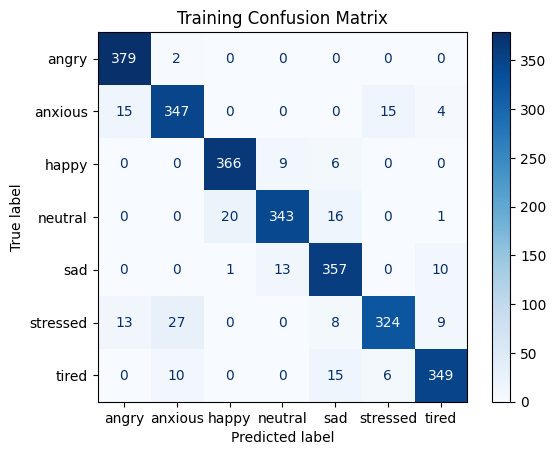

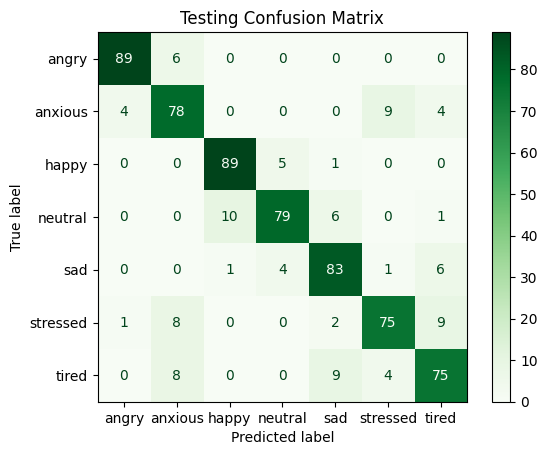

✅ Model training and evaluation complete!


In [ ]:
# ==============================                                                                                    # STEP 12: Evaluation & Confusion Matrix
# ==============================

# Predictions
train_preds = trainer.predict(train_ds)
test_preds = trainer.predict(test_ds)

train_y_true = train_preds.label_ids
train_y_pred = np.argmax(train_preds.predictions, axis=1)

test_y_true = test_preds.label_ids
test_y_pred = np.argmax(test_preds.predictions, axis=1)

print("=== TRAINING METRICS ===")
print(classification_report(train_y_true, train_y_pred, target_names=le.classes_))

print("=== TESTING METRICS ===")
print(classification_report(test_y_true, test_y_pred, target_names=le.classes_))

# Confusion Matrices
ConfusionMatrixDisplay(confusion_matrix(train_y_true, train_y_pred), display_labels=le.classes_).plot(cmap='Blues')
plt.title("Training Confusion Matrix")
plt.show()

ConfusionMatrixDisplay(confusion_matrix(test_y_true, test_y_pred), display_labels=le.classes_).plot(cmap='Greens')
plt.title("Testing Confusion Matrix")
plt.show()

print("✅ Model training and evaluation complete!")